In [1]:
import matplotlib.pyplot as plt
from brian2.only import *

# for the IDE:
import numpy_ as np
import spatial, model, inputs, readout

from util import concatenate
np.concatenate = concatenate
from spike_utils import iterspikes


rng = np.random.default_rng()

N = 100
inhibitory_ratio = .2

params = {
    # Simulation
    'dt': 1*ms,
    
    # Population size
    'N': N,
    'N_exc': int((1-inhibitory_ratio) * N),
    'N_inh': int(inhibitory_ratio * N),

    # Membrane
    'v_rest': -60*mV,
    'v_reset': -74*mV,
    'v_threshold': -54*mV,
    'voltage_init': 'v_rest',
    
    'tau_mem': 30*ms,
    'refractory_exc': 3*ms,
    'refractory_inh': 2*ms,

    # Threshold adaptation - Exc
    'th_tau': 1*second,
    'th_ampl': 1*mV,

    # Short-term plasticity - Exc
    'tau_rec': 150*msecond,
    'U': 0.4,

    # Synapse dynamics
    'E_exc': 0*mV,
    'tau_ampa': 2*msecond,
    'E_inh': -100*mV,
    'tau_gaba': 4*msecond,
    
    # # Stochasticity
    # 'tau_noise': 10*msecond,
    # 'vnoise_std': 0.5*mV,

    # Layout
    'r_dish': 4*mm,
    'weight_distribution': 'singular',
    
    # Connectivity: Inh
    'r_inh': 1*mm,
    'outdeg_inh': 50,
    'w_inh_mean': 1,

    # Connectivity: Exc
    'r_exc': 2*mm,
    'outdeg_exc': 50,
    'w_exc_mean': 1.5,

    # Stimulus
    'N_stimuli': 5,
    'stim_distribution_radius': 2.5*mm,
    'neurons_per_stim': 10,
    'input_strength': 100,

    # Paradigm
    'settling_period': 1*msecond,
    'sequence_length': 5,
    'sequence_count': 10,
    'fully_random_msc': True,
    'fully_random_oddball': True,
    'ISI': 100*ms
}

In [10]:
X, Y, W, D = spatial.create_weights(params, rng)
Xstim, Ystim = spatial.create_stimulus_locations(params)
A, B = params['N_stimuli']-1, rng.choice(params['N_stimuli']-1)

Net = model.create_network(X, Y, Xstim, Ystim, W, D, params,
    reset_dt=inputs.get_episode_duration(params), extras=('u',),
    state_dt=params['dt'], state_vars=['v', 'u', 'th_adapt'])
rundata = readout.setup_run(Net, params, rng, {'A': A, 'B': B})
Net.run(rundata['runtime'])

readout.get_results(Net, params, rundata);

In [ ]:
p=2
for j in range(params['N_exc']):
    plt.axhline(params['v_threshold'], color='grey')
    plt.plot(rundata['dynamics'][0]['A']['std']['th_adapt'][j, p] + params['v_threshold'])
    plt.plot(rundata['dynamics'][0]['A']['std']['v'][j, p])
    plt.plot(rundata['dynamics'][0]['A']['std']['u'][j, p])
    plt.title(j)
    plt.show()

In [17]:
p = 2
j=0
u, v, th_adapt = [rundata['dynamics'][0]['A']['std'][k][j, p] for k in ('u','v','th_adapt')]

Text(0, 0.5, 'Voltage (mV)')

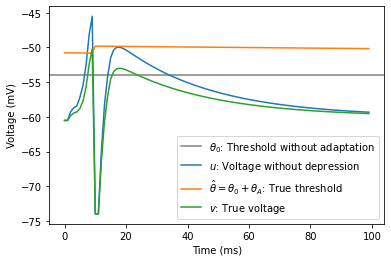

In [18]:
plt.axhline((params['v_threshold'])/mV, color='grey', label='$\\theta_0$: Threshold without adaptation')
plt.plot((u)/mV, label='$u$: Voltage without depression')
plt.plot((th_adapt + params['v_threshold'])/mV, label='$\\hat \\theta = \\theta_0+\\theta_A$: True threshold')
plt.plot((v)/mV, label='$v$: True voltage')
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')

In [19]:
depression = u-v
threshold = th_adapt
activity = u-params['v_threshold']

Text(0, 0.5, 'Voltage influence')

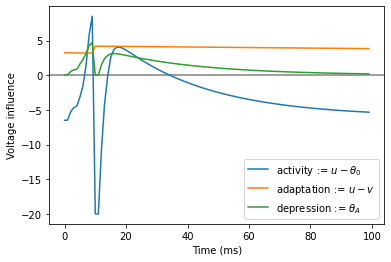

In [20]:
plt.axhline(0, color='grey')
plt.plot(activity/mV, label='activity := $u-\\theta_0$')
plt.plot(threshold/mV, label='adaptation := $u-v$')
plt.plot(depression/mV, label='depression := $\\theta_A$')
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Voltage influence')